In [1]:

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


# Reproducing the results of Baumgart et al
.
We opted not to use the metaphorical terminology of the search theory of Baumgart et al. and rather stick to the target terminology:
Instead of a `Haystack`, we search a `Body`, which instead of containing multiple `Haybales` contains multiple `APCs`, which are either `positive`, making the body `infected` or `negative`, making the body `healthy`.

M := number of positive APCs

N := total number of APCs

$p = M/N :=$ probability of 1 APC to be positive, expressed as an average over all APCs

n := number of checked APCs

k := number of APCs truly identified as positive

$p   =  \frac{M }{N}$

### Global evaluation
When performing a test on multiple APCs, with these metrics you evaluate a T-Cells performance across the whole population to determine how well it can identify a `infected` body.

$TPR =  \frac{TP}{(TP + FN)}$

$FPR =  \frac{FP}{(TN + FP)}$

$TNR =  \frac{TN}{(TN + FP)}$

$FNR =  \frac{FN}{(FN + TP)}$

### Local evaluation
When performing a test on a single APC, with these metrics you evaluate a T-Cells performance on a single case to determine how well it can identify a `positive` APC. While this is not measurable (a population of 1 has either k = 1 for a tp or 0 else), it is controllable via the agent (TCell) policy.

$tpr =  \frac{tp}{(tp + fn)}$

$fpr =  \frac{fp}{(tn + fp)}$

$tnr =  \frac{tn}{(tn + fp)}$

$fnr =  \frac{fn}{(fn + tp)}$






# Setup
## Environment: APC
Each APC is a reinforcement learning environment. It carries the attribute `positiveTendency`, which is either `True` or `False`. This is invisible to the agent. It determines the direction of the evidence function
$$e: t \rightarrow \mathbb{R}$$

### States: S
Each state is an array of three values:
1. the timestep `t`, natural numbers
2. the evidence collected pointing to the APC being positive `q` $\in [0, 1]$. This starts at `0.5` and gets nudged in either direction toward 0 or 1, depending on the environment attribute `positiveTendency`.
3. `1` if this state is a terminal state, `0` at the start of an episode and made positive by the agent

### Actions: A
- `stay`: advance to the next timestep without making a decision
- `positive`: classify the APC to be `positive`
- `negative`: classify the APC to be `negative`

### Rewards: R
The values of the large rewards and penalties are subject to experimentation, as they strongly influence the agent's behaviour.
- `stay`: `-1`, penalty for waiting, encourages making a decision
- `positive`:
    - `tp`: some large reward (e.g. `100`)
    - `fp`: some large penalty (e.g. `-100`)
- `negative`: classify the APC to be `negative`
    - `tn`: some large reward (e.g. `100`)
    - `fn`: some large penalty (e.g. `-100`)

## T-Cell: Agent
The agent for the environments is a TCell.
It has a policy $\pi: S X A \rightarrow \mathbb{R} \in [0,1]$

Since the state-space is continuous, its policy is not tabular but rather a function, which can take many forms. For this purpose we design a `Policy` class, which is flexible and can, for example, be a linear function or a Neural Network.


APC is _negative_

APCThresholdPolicy threshold=0.995
Starting episode:
State t=0, q=0.5, stop=False
a_0: stay

State t=1, q=0.5, stop=False
a_1: stay

State t=2, q=0.3333, stop=False
a_2: stay

State t=3, q=0.25, stop=False
a_3: stay

State t=4, q=0.2, stop=False
a_4: stay

State t=5, q=0.1667, stop=False
a_5: stay

State t=6, q=0.1429, stop=False
a_6: stay

State t=7, q=0.125, stop=False
a_7: stay

State t=8, q=0.1111, stop=False
a_8: stay

State t=9, q=0.1, stop=False
a_9: stay

State t=10, q=0.0909, stop=False
a_10: stay

State t=11, q=0.0833, stop=False
a_11: stay

State t=12, q=0.0769, stop=False
a_12: stay

State t=13, q=0.0714, stop=False
a_13: stay

State t=14, q=0.0667, stop=False
a_14: stay

State t=15, q=0.0625, stop=False
a_15: stay

State t=16, q=0.0588, stop=False
a_16: stay

State t=17, q=0.0556, stop=False
a_17: stay

State t=18, q=0.0526, stop=False
a_18: stay

State t=19, q=0.05, stop=False
a_19: stay

State t=20, q=0.0476, stop=False
a_20: stay

State t=21, q=0.0455

/Users/nikoczernin/Documents/TU/tcells/RL/TCell.py:78: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


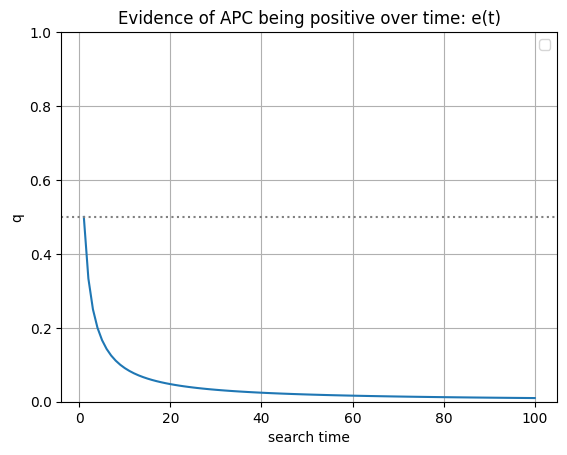

In [2]:
# play a single episode with a TCell
# use a TCell_Threshold
# this TCell variant uses a simple policy that makes a decision solely based on q
# if q is higher than the treshold or the final timestep is reached and q>0.5, it makes a positive classification
# if q is lower than 1-threshold or the final timestep is reached and q<0.5, it makes a negative classification
# otherwise it waits
# if you don't change the threshold/policy, every episode will converge at the same time
from RL.TCell import TCell_Threshold
from RL.APC import StochasticAPC

# StochasticAPC will pick a random value for isPositive, but you can also set it manually
env = StochasticAPC()
print(f"APC is _{'positive' if env.positiveTendency else 'negative'}_\n")
agent = TCell_Threshold(env, threshold=.995)
print(agent.policy)
# agent.policy.plot(agent)
R, t, transitions = agent.episode(verbose=True)
final_action = transitions[-1][1]
final_reward = transitions[-1][2]
print(f"... and the env was {env.positiveTendency} ...")
agent.plot_transitions(transitions)


In [ ]:
import random

# Recreating fig 2
# increase of TPR over the number of examined APCs
# the curve is shaped more flatly with a lower probability of the APC being positive


m = 100 # number of APCs to look into
n = 1000 # number of episodes per param set
env = StochasticAPC()
thresh = 0.996

experiment_dfs = []

p = 0.1
ps = [0.5, 0.1, 0.01, 0.001, 0.0001]

for p in ps:

    results = []
    agent = TCell_Threshold(env, T=300, threshold=thresh)
    for i in range(m):
        for j in range(n):
            # reset the env
            agent.env.reset()
            # manually set the environment tendency
            agent.env.positiveTendency = random.random() < p
            R, t, transitions = agent.episode(epsilon=0, verbose=False)
            final_action = transitions[-1][1]
            final_reward = transitions[-1][2]
            result = env.eval_action_reward(final_action, final_reward)
            results.append({"result":result, "t":t, "m": j, "n": i, "p": p})


    results = pd.DataFrame(results)

    results_wide = results.sort_values(["m", "n"]).groupby(["m", "n"])["result"].value_counts().unstack(fill_value=0).reset_index()
    # results_wide

    sum_cols = results.result.unique() #["FN", "FP", "TN", "TP"]

    # sort so n increases within each m
    results_wide = results_wide.sort_values(["m", "n"], kind="mergesort")

    # cumsum within each m, n stays unchanged
    results_wide[sum_cols] = results_wide.groupby("m", sort=False)[sum_cols].cumsum()
    # create default columns in case something never came up
    results["TP"] = results.get("TP", 0)
    results["FP"] = results.get("FP", 0)
    results["TN"] = results.get("TN", 0)
    results["FN"] = results.get("FN", 0)
    # TPR = TP / (TP + FN)
    results_wide["TPR"] = results_wide["TP"] / (results_wide["FN"] + results_wide["TP"] + 1)
    # results_wide

    mean_results_wide = results_wide.groupby("n", as_index=False).mean()
    mean_results_wide["p"] = p

    experiment_dfs.append(mean_results_wide)


# Combine
df_all = pd.concat(experiment_dfs, ignore_index=True)


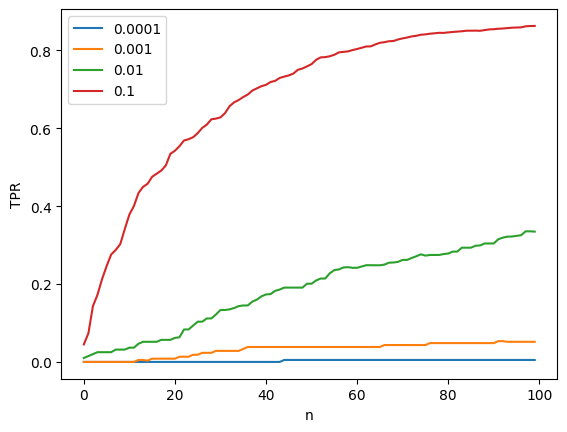

In [38]:
# Plot each experiment separately
for exp, df_exp in df_all.groupby("p"):
    plt.plot(df_exp["n"], df_exp["TPR"], label=exp)

plt.xlabel("n")
plt.ylabel("TPR")
plt.legend()
plt.show()


result,m,n,FN,FP,TN,TP,TPR
0,0,0,0,0,1,0,0.000000
1,0,1,0,0,3,0,0.000000
2,0,2,0,0,5,1,0.500000
3,0,3,0,0,8,2,0.666667
4,0,4,0,0,12,3,0.750000
...,...,...,...,...,...,...,...
9995,99,95,0,0,4074,582,0.998285
9996,99,96,0,0,4162,591,0.998311
9997,99,97,0,0,4250,601,0.998339
9998,99,98,0,0,4339,611,0.998366


<Axes: xlabel='num searched APCs'>

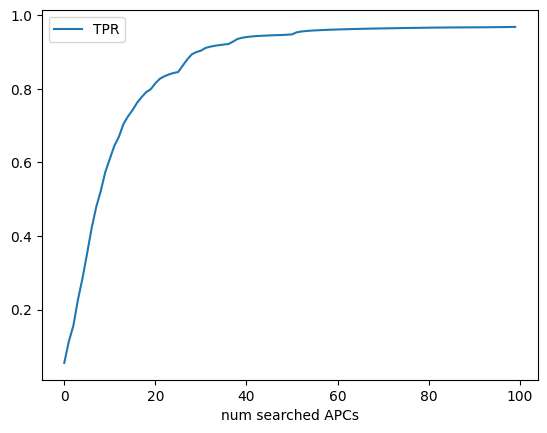

In [28]:
mean_results_wide
mean_results_wide.plot.line("n", "TPR", xlabel="num searched APCs", title="")


In [5]:

results = results.groupby("n")["result"].value_counts().unstack(fill_value=0).reset_index()
results["TP"] = results.get("TP", 0)
results["FP"] = results.get("FP", 0)
results["TN"] = results.get("TN", 0)
results["FN"] = results.get("FN", 0)
results["TPR"] = results["TP"] / (results["TP"] + results["FN"] + 1)
# # compute the rolling mean (centered so it smooths past & future points)
results['TPR_smooth'] = (
    results['TPR']
    .rolling(window=3, min_periods=1, center=True)
    .mean()
)
print(results)
results.plot.line("n", "TPR", xlabel="num searched APCs", title="")
# results.plot.line("n", "TPR_smooth", xlabel="search time", title="Search time vs TPR")



result,n,FN,FP,TN,TP,TPR,TPR_smooth
0,0,2,0,87,11,0.785714,0.854396
1,1,0,0,88,12,0.923077,0.847375
2,2,1,0,89,10,0.833333,0.844729
3,3,1,0,92,7,0.777778,0.846561
4,4,0,0,87,13,0.928571,0.850834
...,...,...,...,...,...,...,...
95,95,1,0,93,6,0.750000,0.833838
96,96,0,0,86,14,0.933333,0.857407
97,97,0,0,92,8,0.888889,0.885185
98,98,0,0,95,5,0.833333,0.885185


Baumgart et al. display a plot that shows the development of the global TPR as the number of checked APCs increases, for different probabilities of harmfulness. Here we recreate this plot using our environments


result    t     FN     FP     TN     TP       TPR  TPR_smooth
0         2  22161  22286  44553  44500  0.667547    0.709315
1         3   8214   8380  25118  24788  0.751083    0.739197
2         4   4020   3922  16078  15980  0.798960    0.793447
3         5   2245   2231  11035  10989  0.830298    0.828443
4         6   1378   1350   8070   8202  0.856069    0.852371
..      ...    ...    ...    ...    ...       ...         ...
68      177      1      0    255    244  0.991870    0.990845
69      199      0      3    241    256  0.996109    0.993192
70      228      1      0    263    236  0.991597    0.994644
71      266      0      0    236    264  0.996226    0.994832
72      299      4      4   1494   1498  0.996673    0.996450

[73 rows x 7 columns]


<Axes: title={'center': 'Search time vs TPR'}, xlabel='search time'>

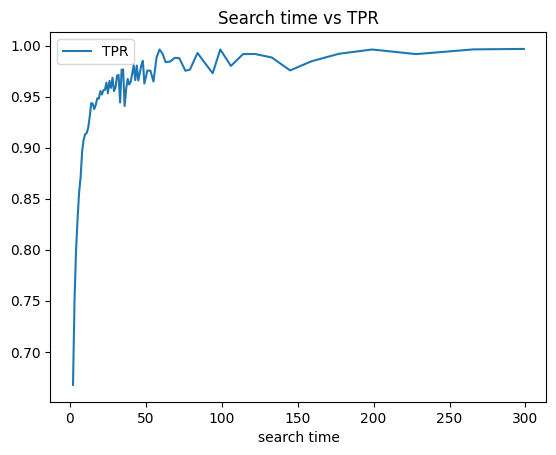

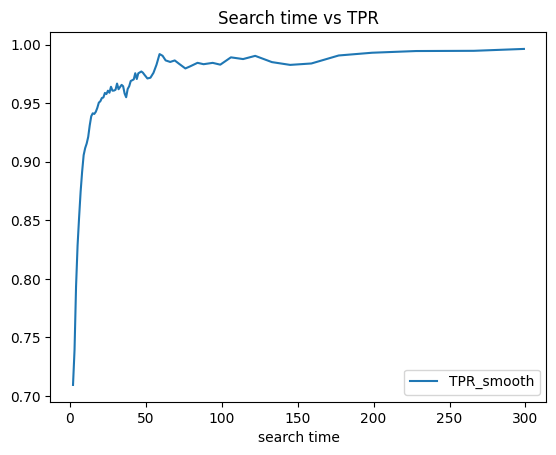

In [5]:


n=500
# test many different TCell_Treshold instances with
# varying thresholds
# plot their results: FPR vs treshold
env = StochasticAPC()
results = []

num_steps = 800  # number of steps
for thresh in np.linspace(0.5, 1.0, num_steps):
    # make 100 episodes per each of the 100 different treshold levels
    agent = TCell_Threshold(env, T=300, threshold=thresh)
    for j in range(n):
        # reset the env
        agent.env.reset()
        R, t, transitions = agent.episode(epsilon=0.1, verbose=False)
        final_action = transitions[-1][1]
        final_reward = transitions[-1][2]
        result = env.eval_action_reward(final_action, final_reward)
        results.append({"result":result, "t":t, "thresh": thresh})
results = pd.DataFrame(results)
results = results.groupby("t")["result"].value_counts().unstack(fill_value=0).reset_index()
results["TP"] = results.get("TP", 0)
results["FP"] = results.get("FP", 0)
results["TN"] = results.get("TN", 0)
results["FN"] = results.get("FN", 0)
results["TPR"] = results["TP"] / (results["TP"] + results["FN"] + 1)
# compute the rolling mean (centered so it smooths past & future points)
results['TPR_smooth'] = (
    results['TPR']
    .rolling(window=3, min_periods=1, center=True)
    .mean()
)
print(results)
results.plot.line("t", "TPR", xlabel="search time", title="Search time vs TPR")
results.plot.line("t", "TPR_smooth", xlabel="search time", title="Search time vs TPR")

